In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
N = 20000

In [3]:
ip = np.random.rand(N) > 0.5
ip = ip.astype(int)


In [4]:
s = 2 * ip - 1

In [5]:
Es = 1

In [6]:
eb_no_db = np.arange(0,25)

In [7]:
ber_RxMF_EPA = np.zeros(len(eb_no_db))

ber_RxZF_EPA = np.zeros(len(eb_no_db))

In [8]:
def calculate_ber(eb_no_db,nTx,nRx,jj,Rz_inverse):
    
    
    equalize_bits = []
    
    for ii in range(N//2):
        
        H = (1/np.sqrt(2)) * (np.random.randn(nRx,nTx) + 1j * np.random.randn(nRx,nTx))
        
        n = (1/np.sqrt(2)) * (np.random.randn(2,1) + 1j * np.random.randn(2,1))
        
        x1 = s[2 * ii]
        
        x2 = s[2 * ii + 1]
        
        x =np.array([[x1],[x2]])
        
        
        
        Ns = np.linalg.matrix_rank(H)
        
        P = np.sqrt(Es / Ns) * np.vstack([
               np.eye(Ns),                
             np.zeros((nTx-Ns, Ns))           
          ])
        
        
        
        y = H @ P @ x + n * (10 ** (-eb_no_db[jj] / 20))
        
        
        H_hermitian = np.conjugate(H)
        
        H_hermitian = np.transpose(H_hermitian)
        
        P_hermitian = np.conjugate(P)
        
        P_hermitian = np.transpose(P_hermitian)
        
        W = P_hermitian @ H_hermitian @ Rz_inverse
        
        x_hat = np.dot(W,y)
        
        x_hat = np.real(x_hat > 0).astype(int)
        
        equalize_bits.append(x_hat[0,0])
        
        equalize_bits.append(x_hat[1,0])
        
    nErr = np.sum(ip != equalize_bits)
    
    return nErr
         

In [9]:
def calculate_ber_ZF(eb_no_db,nTx,nRx,jj,Rz_inverse):
    
    
    equalize_bits = []
    
    for ii in range(N//2):
        
        H = (1/np.sqrt(2)) * (np.random.randn(nRx,nTx) + 1j * np.random.randn(nRx,nTx))
        
        n = (1/np.sqrt(2)) * (np.random.randn(2,1) + 1j * np.random.randn(2,1))
        
        x1 = s[2 * ii]
        
        x2 = s[2 * ii + 1]
        
        x =np.array([[x1],[x2]])
        
        
        
        Ns = np.linalg.matrix_rank(H)
        
        P = np.sqrt(Es / Ns) * np.vstack([
               np.eye(Ns),                
             np.zeros((nTx-Ns, Ns))           
          ])
        
        
        
        y = H @ P @ x + n * (10 ** (-eb_no_db[jj] / 20))
        
        
        H_hermitian = np.conjugate(H)
        
        H_hermitian = np.transpose(H_hermitian)
        
        P_hermitian = np.conjugate(P)
        
        P_hermitian = np.transpose(P_hermitian)
        
        W = np.linalg.inv(P_hermitian @ H_hermitian @ Rz_inverse @ H @ P) 
        
        W = W @ P_hermitian @ H_hermitian @ Rz_inverse
        
        x_hat = np.dot(W,y)
        
        x_hat = np.real(x_hat > 0).astype(int)
        
        equalize_bits.append(x_hat[0,0])
        
        equalize_bits.append(x_hat[1,0])
        
    nErr = np.sum(ip != equalize_bits)
    
    return nErr
    
    

In [10]:
def RxMF():
    
    
    for jj in range(len(eb_no_db)):
        
        nTx = 2
        
        nRx = 2
        
        snr = 10**(eb_no_db[jj] / 10)
        
        noise_variance = (1/snr)
        
        Rz = noise_variance * np.eye(nRx)
        
        Rz_inverse = np.linalg.inv(Rz)
        
        bit_error = calculate_ber(eb_no_db,nTx,nRx,jj,Rz_inverse)
        
        ber_RxZF_EPA[jj] = bit_error / N
        
        
    return ber_RxZF_EPA
        
        
        

In [11]:
def RxZF():
    
    for jj in range(len(eb_no_db)):
        
        nTx = 2
        
        nRx = 2
        
        snr = 10**(eb_no_db[jj] / 10)
        
        noise_variance = (1/snr)
        
        Rz = noise_variance * np.eye(nRx)
        
        Rz_inverse = np.linalg.inv(Rz)
        
        bit_error = calculate_ber_ZF(eb_no_db,nTx,nRx,jj,Rz_inverse)
        
        ber_RxMF_EPA[jj] = bit_error / N
        
        
    return ber_RxMF_EPA
        
        

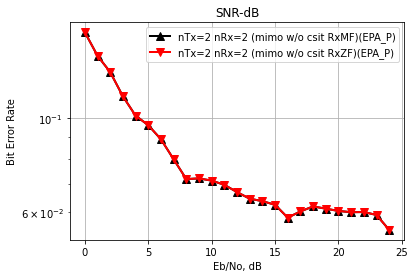

In [12]:
rxmf_epa = RxMF()

rxzf_epa = RxZF()

plt.figure()

plt.semilogy(eb_no_db, rxmf_epa, 'k^-', linewidth=2, markersize=8, label='nTx=2 nRx=2 (mimo w/o csit RxMF)(EPA_P)')

plt.semilogy(eb_no_db, rxmf_epa, 'rv-', linewidth=2, markersize=8, label='nTx=2 nRx=2 (mimo w/o csit RxZF)(EPA_P)')

plt.grid(True)
plt.legend()
plt.xlabel('Eb/No, dB')
plt.ylabel('Bit Error Rate')
plt.title('SNR-dB')
plt.show()